## Scratchpad

In [1]:
# Set up:
# %matplotlib widget
# %matplotlib inline
# %matplotlib ipympl
# %matplotlib notebook
import pandas as pd
import numpy as np

# Plotting Packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", dpi=150, bbox_inches="tight")

# import plotly.graph_objects as go
# import plotly.express as px
# import ipywidgets as widget

# Computation packages
from scipy.spatial.distance import euclidean
from scipy.signal import find_peaks
from fastdtw import fastdtw

In [2]:
from nah.loader import load_raw_csv_data, load_npzs
from nah.utils import norm_data, full_align, full_joint_align, clean_rot_data, segment_by_demo,sum_of_squares

from nah.plot import plot_norm, plot_pos, plot_rot, plot_raw_data,view_participant_robot_gesture, plot_rot_2D

In [21]:
## SCRATCHPAD STUFF BEGINS HERE

PID = 4
gesture_num=1
demo_num = 1
followup = False
demo_max=5

robot_name = "Reachy"
end_eff_name = "r_wrist2hand_"

# robot_name = "j2s6s300"
# end_eff_name = "j2s6s300_end_effector_"

end_eff_data, camera_data, rh_data, lh_data, joint_data = load_npzs(robot_name, PID, followup, gesture_num)

end_eff_multi_demo, camera, rh, lh, joints = segment_by_demo(end_eff_data, camera_data, rh_data, lh_data, joint_data, demo_max)
# end_eff = np.array(end_eff)
# temp = norm_data(sum_of_squares(rh[0]),sum_of_squares(rh[1]))
# temp = norm_data(sum_of_squares(end_eff[0]),sum_of_squares(end_eff[1]))
temp = norm_data(sum_of_squares(end_eff_multi_demo[0]),sum_of_squares(end_eff_multi_demo[1]))
    # ax.set_title("DTW Alignment of Hand and URDF End-Effector Orientation", fontsize=20, fontweight="bold")
# plt.savefig('DTW_UnitTest.png')
    # plt.close('all')

In [4]:
    # Ideally, also need to normalize by participant height (wingspan)
    # And clip ends (~1sec at beginning, 2sec at end (but DTW should help with this))
    # np.where(time_hand_aligned>time_hand_aligned[0]+1)[0][0]

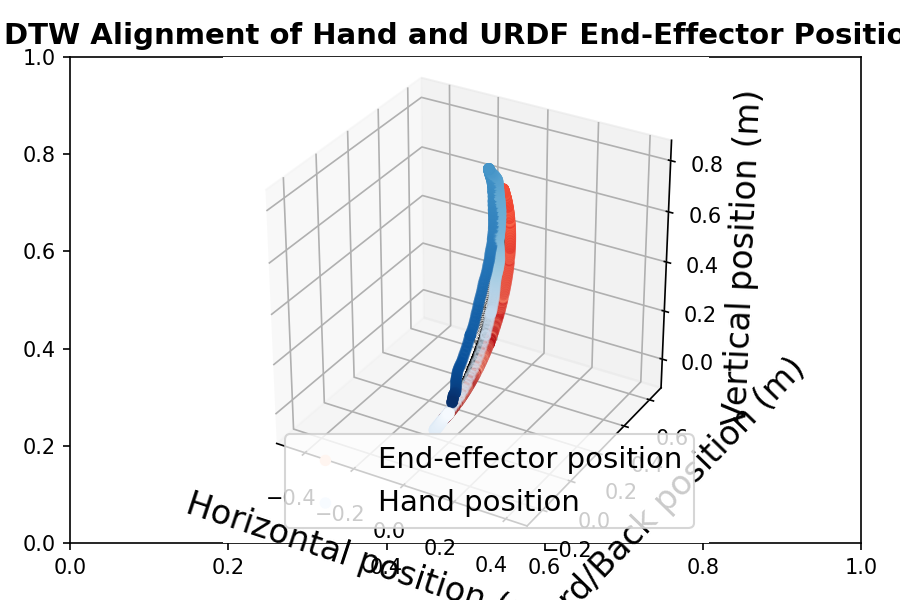

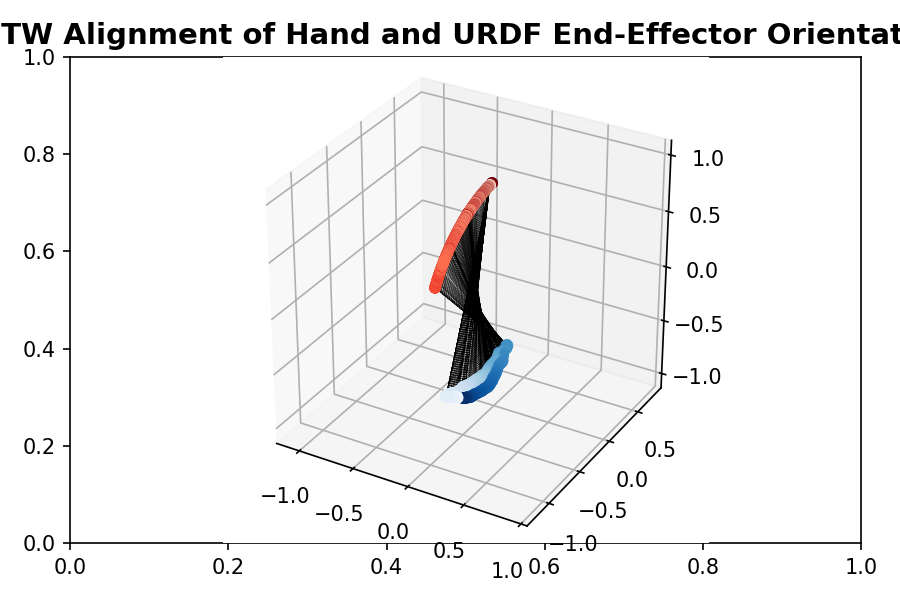

In [4]:
%matplotlib widget

traj1 = end_eff_multi_demo[0]
traj2 = rh[0]

try:
    # Test run for now, with robot end-effector demos. (Should be identical and need no alignment)
    warp_path, _, _ = norm_data(sum_of_squares(traj1),sum_of_squares(traj2)) 
except:
    print("Warp data failed")
    raise
try:
    time_URDF_aligned, time_hand_aligned, end_eff_pos_aligned, end_eff_rot_aligned, hand_pos_aligned, hand_rot_aligned = \
        full_align(warp_path, traj1, traj2)
    hand_rot_aligned = clean_rot_data(gesture_num, demo_num, hand_rot_aligned)
    # plot_rot_2D(time_hand_aligned, hand_rot_aligned)
    hand_rot_aligned = clean_rot_data(gesture_num, demo_num, hand_rot_aligned) #Seems to work better if you do it twice for some reason
    # plot_rot_2D(time_hand_aligned, hand_rot_aligned)
except:
    print("Align data failed")
    raise 
try:
    plot_pos(gesture_num, demo_num, warp_path, end_eff_pos_aligned, hand_pos_aligned, time_URDF_aligned, time_hand_aligned)
    plot_rot(gesture_num, demo_num, warp_path, end_eff_rot_aligned, hand_rot_aligned, time_URDF_aligned, time_hand_aligned)

    """ TODO(Jennifer)
    Note from this sample that DTW seems to get stuck with its alignment on just the participant's motion in one direction.
    This could mean one of two things (or both):
    1) the distance metric is not correctly chosen. (Right now it is hand distance from the user's head vs end-effector distance 
        from the origin of the scene. The local origins may not be sufficiently similar; in a pinch, moving the origin far away
        might help.)
    2) There is trailing data that needs to be clipped off the end. For demos, my estimate is that we can clip off one second 
        of data. For aligned stuff, we can probably look for the final position of the robot end-effector, find the time stamp
        for when the robot reached that point (within some small margin, as Unity doesn't hold the robot perfectly still), and
        search for the first point in the human hand trajectory that maps to that point. All subsequent robot and human user 
        data can be clipped.

    It also looks like the graph is plotting the hand motion and robot motion on different axes. Figure out why...? Honestly,
    the user's hand motion just looks way more jittery than it should be based on the plots we were looking at in 
    Batch_Data_Processing and Trajectory_Alignment
    """
except:
    print("Plot data failed")
    raise

In [6]:
plt.close('all')

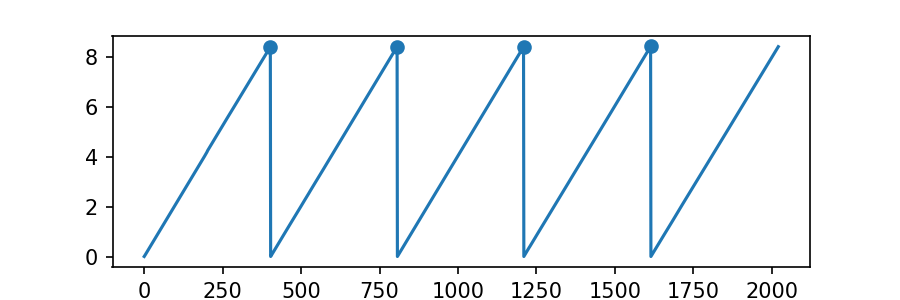

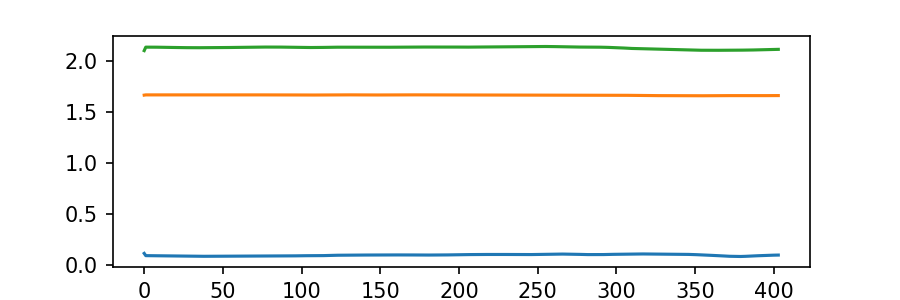

In [27]:
fig, ax = plt.subplots(figsize=(6,2))
fig.patch.set_visible(True)
ax.axis('on')
# ax = plt.axes(projection='3d')  
# ax.view_init(30,60)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

peaks, _ = find_peaks(end_eff_data[:,0], height=0)
ax.plot(end_eff_data[:,0])
ax.scatter(peaks,end_eff_data[peaks,0])

demo_max=2
end_eff=['']*demo_max
rh     =['']*demo_max
lh     =['']*demo_max
joints =['']*demo_max

for i in range(0,demo_max):
    if i==0:
        end_eff[i] = end_eff_data[1:peaks[0],:]
        rh[i]      =      rh_data[1:peaks[0],:]
        lh[i]      =      lh_data[1:peaks[0],:]
        joints[i]  =   joint_data[1:peaks[0],:]
    else:
        end_eff[i] = end_eff_data[peaks[i-1]:peaks[i],:]
        rh[i]      =      rh_data[peaks[i-1]:peaks[i],:]
        lh[i]      =      lh_data[peaks[i-1]:peaks[i],:]
        joints[i]  =   joint_data[peaks[i-1]:peaks[i],:]

fig, ax = plt.subplots(figsize=(6,2))
fig.patch.set_visible(True)
ax.axis('on')
ax.plot(camera[1][:,1])
ax.plot(camera[1][:,2])
ax.plot(camera[1][:,3])

In [16]:
def hand_range(hand_data):
    movement_range = np.zeros([3, 1])
    for i in range(1, 4):
        movement_range[i -
                       1] = np.max(hand_data[:, i]) - np.min(hand_data[:, i])

    return np.linalg.norm(movement_range)

In [25]:
print(hand_range(rh[0]))
print(hand_range(lh[0]))
print(hand_range(camera[0]))

0.924872835706212
0.05892079299619116
0.036385051473922944


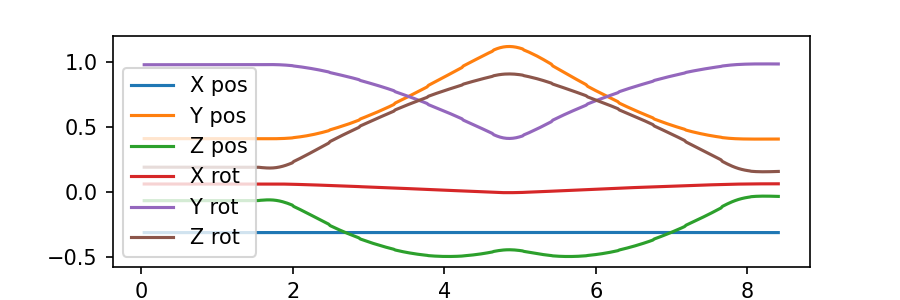

In [8]:
fig, ax = plt.subplots(figsize=(6,2))
fig.patch.set_visible(True)
ax.axis('on')
ax.plot(end_eff[0][:,0],end_eff[0][:,1],label="X pos")
ax.plot(end_eff[0][:,0],end_eff[0][:,2],label="Y pos")
ax.plot(end_eff[0][:,0],end_eff[0][:,3],label="Z pos")
ax.plot(end_eff[0][:,0],end_eff[0][:,4],label="X rot")
ax.plot(end_eff[0][:,0],end_eff[0][:,5],label="Y rot")
ax.plot(end_eff[0][:,0],end_eff[0][:,6],label="Z rot")

ax.legend()

In [9]:
np.where(time_hand_aligned>time_hand_aligned[0]+1)[0][0]

48

NameError: name 'ja_data_aligned' is not defined

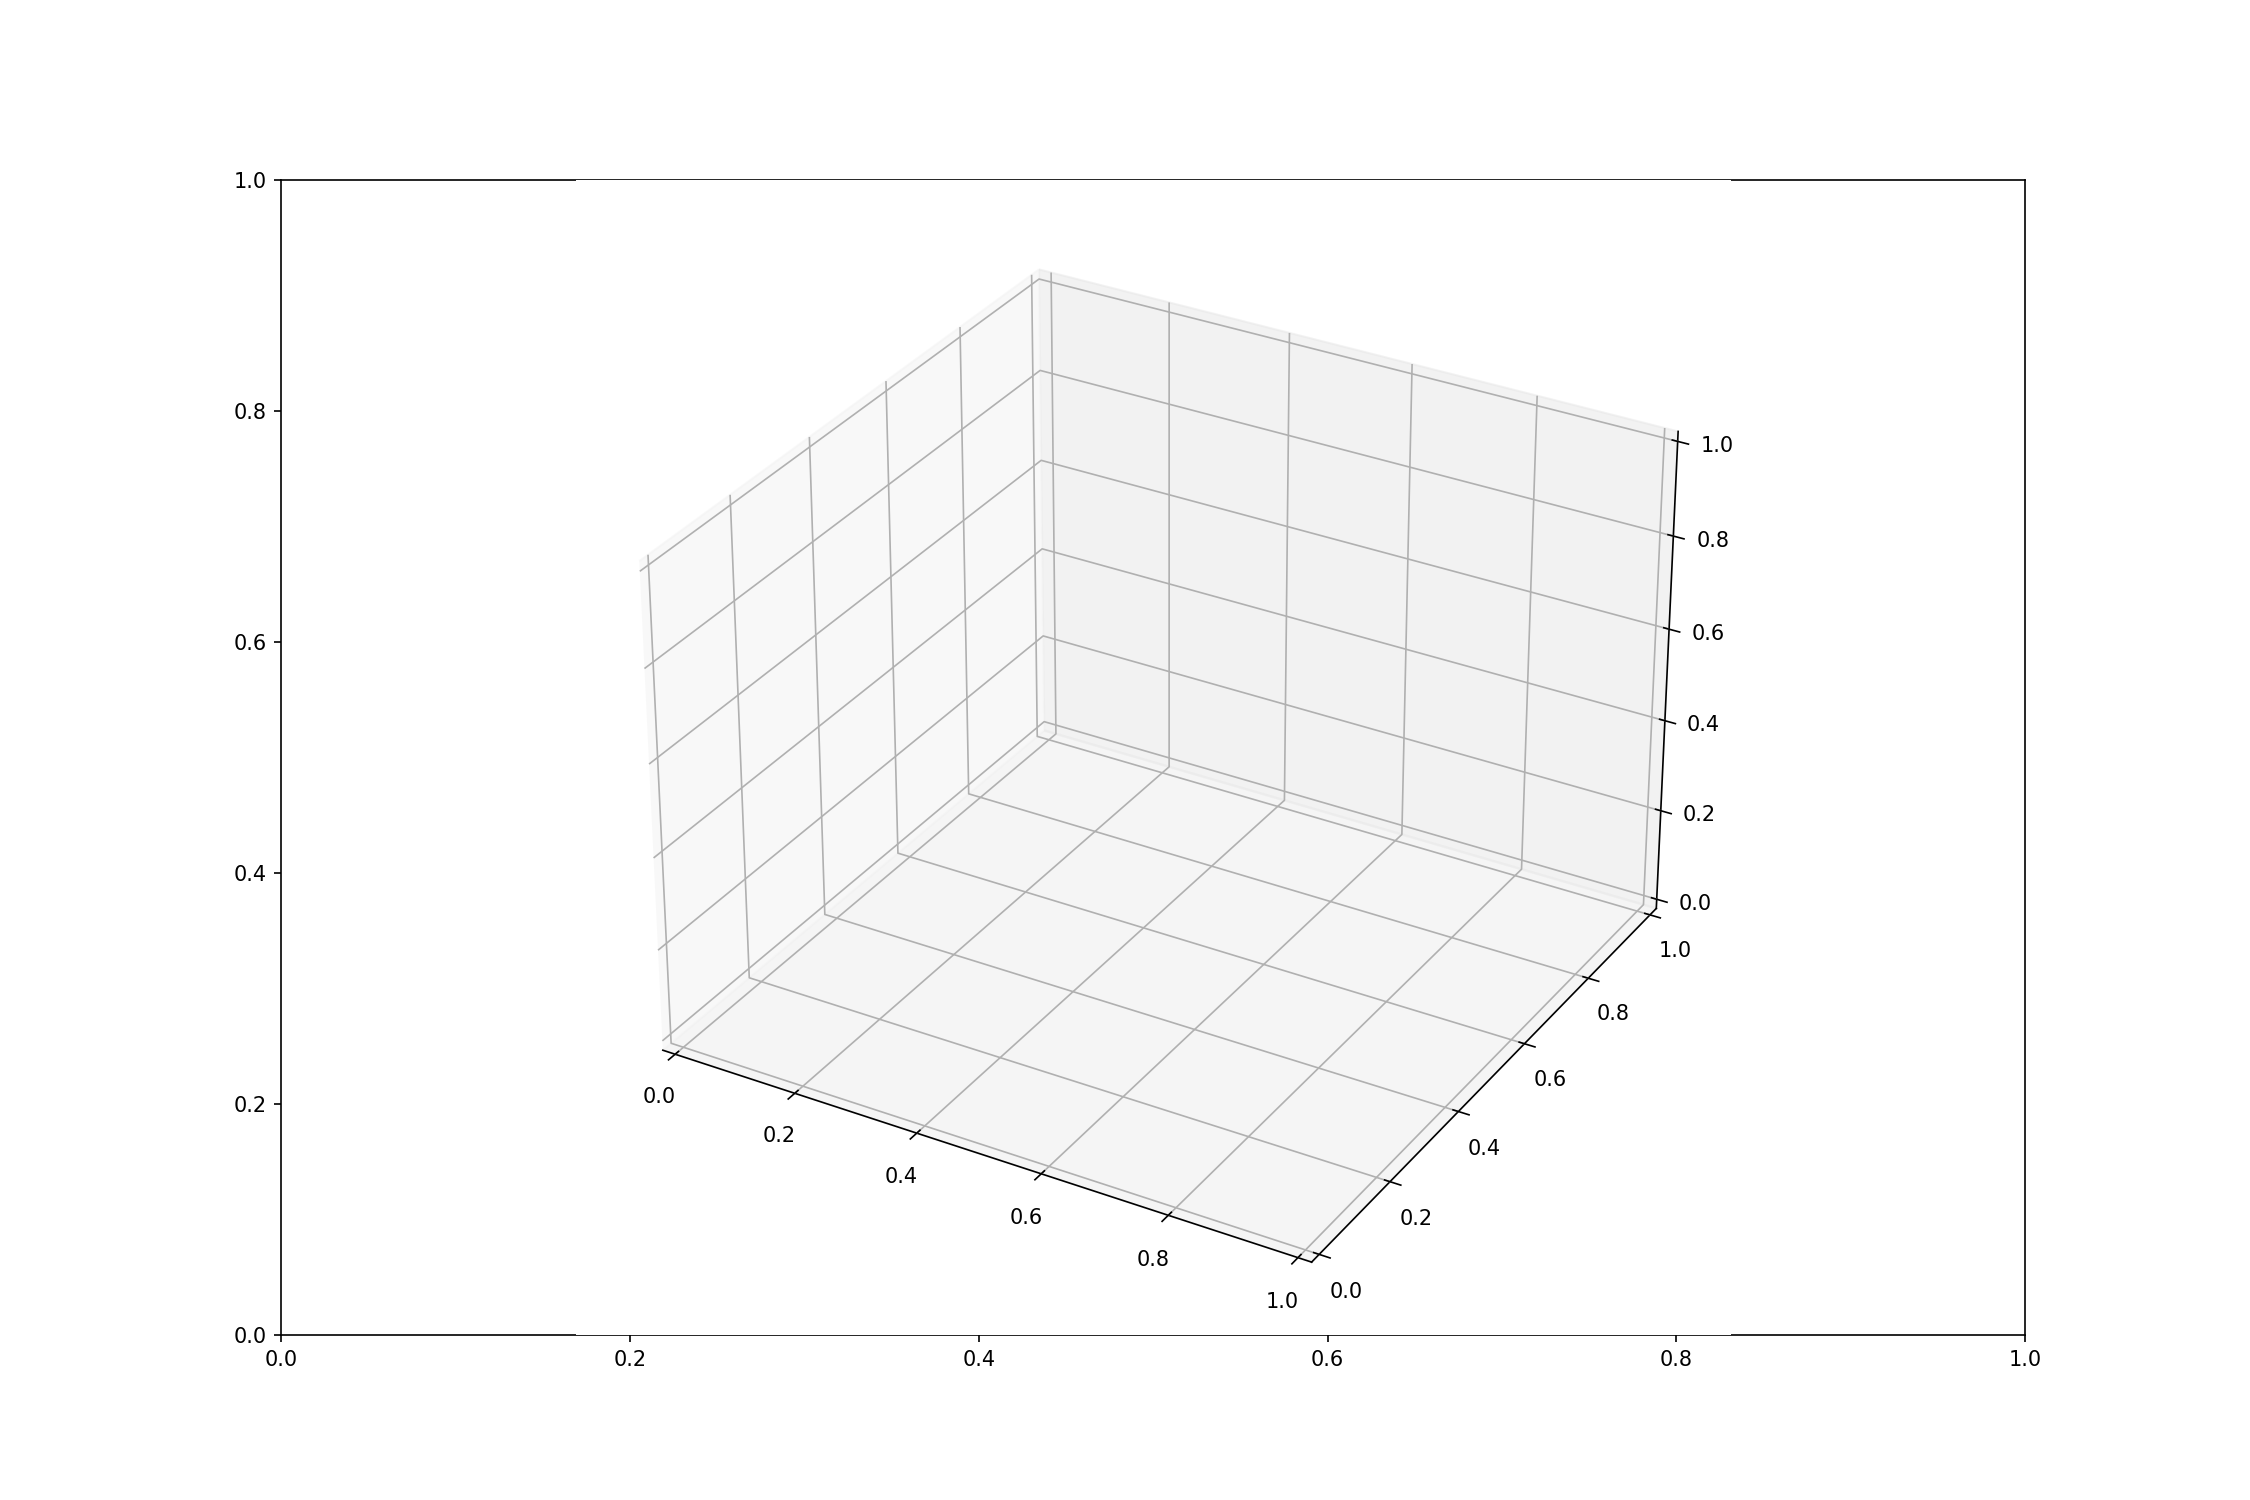

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_visible(True)
ax.axis('on')

ax = plt.axes(projection='3d')

ax.scatter(ja_data_aligned[...,2], ja_data_aligned[...,3], ja_data_aligned[...,4], \
          c=time_ja_aligned/max(time_ja_aligned), cmap='Reds', label='Joint Angle Values')
ax.scatter(hand_data_aligned[...,0]   , -hand_data_aligned[...,2]   , hand_data_aligned[...,1]   , \
          c=time_hand_aligned/max(time_hand_aligned), cmap='Blues', label='Hand position')

for [map_x, map_y] in warp_path_ja: 
    ax.plot3D([ja_data_aligned[map_x].T[2], hand_data_aligned[map_y].T[0]], \
              [ja_data_aligned[map_x].T[3], -hand_data_aligned[map_y].T[2]],\
              [ja_data_aligned[map_x].T[4], hand_data_aligned[map_y].T[1]], \
              '--k', linewidth=0.2)
    
ax.set_xlabel('Horizontal position')
ax.set_ylabel('Forward/Back position')
ax.set_zlabel('Vertical position')

ax.set_title("DTW Alignment of Hand Position and First Three URDF Joint Angles", fontsize=10, fontweight="bold")
